<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

## Part 3: Hyperparameter Tuning & Evaluation

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC

In [2]:
hbo_netflix = pd.read_csv('../data/hbo_netflix.csv')

In [3]:
hbo_netflix.head()

,Unnamed: 0,subreddit,combined,post_length,tokens_lem
0,0,0,Ok favorite all time HBO Series and favorite c...,104,ok favorite favorite inspired earlier post wir...
1,1,0,OC HBO Series Season Premiere v Finale Change ...,59,oc premiere v finale change viewership
2,2,0,anyone know the release date for White house p...,100,release date white house plumber online say march
3,3,0,Who is your all time favorite character from a...,58,favorite
4,4,0,My top HBO series The Wire Chernobyl The Sopra...,194,wire chernobyl soprano band brother game thron...


In [4]:
X = hbo_netflix['tokens_lem']
y = hbo_netflix['subreddit']

In [5]:
hbo_netflix[hbo_netflix['tokens_lem'].isna()]

,Unnamed: 0,subreddit,combined,post_length,tokens_lem
985,9,1,Looking for a tv series to watch,32,NaN
1027,56,1,where can i watch those,23,NaN
1117,165,1,Help me find a movie on Netflix,31,NaN
1164,218,1,Why Netflix has so many bad shows,33,NaN
1940,116,1,Help me find this Series,24,NaN


In [6]:
hbo_netflix.dropna(inplace=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, random_state= 42)

In [8]:
hbo_netflix['tokens_lem'].apply(type).value_counts()

<class 'str'>    1952
Name: tokens_lem, dtype: int64

In [9]:
# Remove NaN values from X_train and y_train
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

# Remove NaN values from X_test and y_test
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

### Naive Bayes - Multinomial

#### Count Vectorizer

In [10]:
#### Set up pipeline with 2 stages
pipe_cvec_nb = Pipeline([
    ('cvec1', CountVectorizer()),
    ('nb1', MultinomialNB())
    ])

In [11]:
pipe_cvec_nb.get_params()

{'memory': None,
 'steps': [('cvec1', CountVectorizer()), ('nb1', MultinomialNB())],
 'verbose': False,
 'cvec1': CountVectorizer(),
 'nb1': MultinomialNB(),
 'cvec1__analyzer': 'word',
 'cvec1__binary': False,
 'cvec1__decode_error': 'strict',
 'cvec1__dtype': numpy.int64,
 'cvec1__encoding': 'utf-8',
 'cvec1__input': 'content',
 'cvec1__lowercase': True,
 'cvec1__max_df': 1.0,
 'cvec1__max_features': None,
 'cvec1__min_df': 1,
 'cvec1__ngram_range': (1, 1),
 'cvec1__preprocessor': None,
 'cvec1__stop_words': None,
 'cvec1__strip_accents': None,
 'cvec1__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec1__tokenizer': None,
 'cvec1__vocabulary': None,
 'nb1__alpha': 1.0,
 'nb1__class_prior': None,
 'nb1__fit_prior': True}

In [12]:
pipe_cvec_nb_params = {
    'cvec1__max_features': [None],
    'cvec1__min_df': [1], 
    'cvec1__max_df': [0.1],
    'cvec1__ngram_range': [(1,4)],
    'nb1__alpha': [0.1]
    }

In [13]:
gs_cvec_nb = GridSearchCV(pipe_cvec_nb, param_grid=pipe_cvec_nb_params, n_jobs=-1, cv=5)

In [14]:
gs_cvec_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec1', CountVectorizer()),
                                       ('nb1', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec1__max_df': [0.1], 'cvec1__max_features': [None],
                         'cvec1__min_df': [1], 'cvec1__ngram_range': [(1, 4)],
                         'nb1__alpha': [0.1]})

In [15]:
gs_cvec_nb.best_score_

0.7807377624012343

In [17]:
gs_cvec_nb.best_params_

{'cvec1__max_df': 0.1,
 'cvec1__max_features': None,
 'cvec1__min_df': 1,
 'cvec1__ngram_range': (1, 4),
 'nb1__alpha': 0.1}

In [18]:
gs_cvec_nb_train_score = gs_cvec_nb.score(X_train, y_train)
gs_cvec_nb_test_score = gs_cvec_nb.score(X_test, y_test)

print(f'Train Score: {gs_cvec_nb_train_score.round(3)}')
print(f'Test Score: {gs_cvec_nb_test_score.round(3)}')

Train Score: 0.996
Test Score: 0.803


In [19]:
y_pred_gs_cvec_nb = gs_cvec_nb.predict(X_test)

accuracy_gs_cvec_nb = accuracy_score(y_test, y_pred_gs_cvec_nb)
recall_gs_cvec_nb = recall_score(y_test, y_pred_gs_cvec_nb)
precision_gs_cvec_nb = precision_score(y_test, y_pred_gs_cvec_nb)
f1_gs_cvec_nb = f1_score(y_test, y_pred_gs_cvec_nb)

print(f'Prediction Accuracy: {accuracy_gs_cvec_nb.round(3)}\nPrediction Recall: {recall_gs_cvec_nb.round(3)}\nPrediction Precision: {precision_gs_cvec_nb.round(3)}\nPrediction F1: {f1_gs_cvec_nb.round(3)}')

Prediction Accuracy: 0.803
Prediction Recall: 0.828
Prediction Precision: 0.789
Prediction F1: 0.808


In [20]:
def plot_cm_roc(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    annot_labels = []
    for index,value in enumerate(cm):
        if index == 0:
            annot_labels.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
        if index == 1:
            annot_labels.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])
    
    accuracy = round((cm[0][0]+cm[1][1])/sum(sum(cm)),3)
    precision = round(cm[1][1]/(cm[0][1]+cm[1][1]),3)
    recall = round(cm[1][1]/(cm[1][0]+cm[1][1]),3)
    f1 = round(2*(precision*recall)/(precision+recall),3)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plt.subplots_adjust(wspace=0.4)

    sns.heatmap(cm, annot=np.array(annot_labels),
                fmt="",
                annot_kws={"size": 14},
                linewidths=.5,
                square = True,
                cmap = 'Greens',
                xticklabels = ['HBO', 'Netflix'],
                yticklabels = ['HBO', 'Netflix'],
                ax=axes[0])
    axes[0].set_ylabel('Actual', fontsize = 14);
    axes[0].set_xlabel('Predicted', fontsize = 14);
    axes[0].set_title('Confusion Matrix', size = 16);

    plot_roc_curve(model, X_test, y_test, ax=axes[1])
    axes[1].plot([0, 1], [0, 1], label='baseline', linestyle='--')
    axes[1].legend();
    axes[1].set_title('ROC Curve', size = 16)

    plt.suptitle(title+'\n'
                  +'Accuracy: {:.3f}'.format(accuracy)+'\n'
                  +'Precision: {:.3f}'.format(precision)+'\n'
                  +'Recall: {:.3f}'.format(recall)+'\n'
                  +'F1: {:.3f}'.format(f1)+'\n', size = 11);

    plt.show()

/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


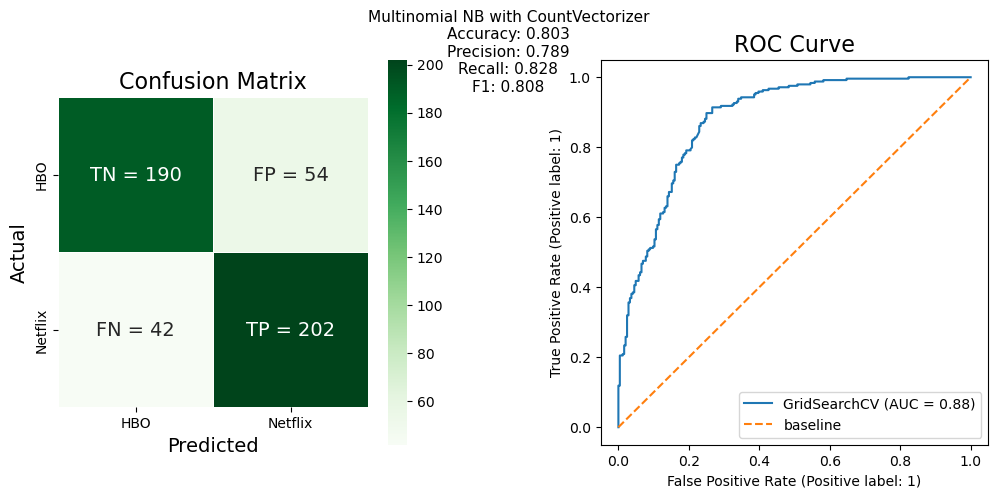

In [21]:
plot_cm_roc(gs_cvec_nb, X_test, y_test, 'Multinomial NB with CountVectorizer')

#### TF-IDF Vectorizer

In [22]:
pipe_tfidf_nb = Pipeline([('tfidf2', TfidfVectorizer()),
                ('nb2', MultinomialNB())])

In [23]:
pipe_tfidf_nb.get_params()

{'memory': None,
 'steps': [('tfidf2', TfidfVectorizer()), ('nb2', MultinomialNB())],
 'verbose': False,
 'tfidf2': TfidfVectorizer(),
 'nb2': MultinomialNB(),
 'tfidf2__analyzer': 'word',
 'tfidf2__binary': False,
 'tfidf2__decode_error': 'strict',
 'tfidf2__dtype': numpy.float64,
 'tfidf2__encoding': 'utf-8',
 'tfidf2__input': 'content',
 'tfidf2__lowercase': True,
 'tfidf2__max_df': 1.0,
 'tfidf2__max_features': None,
 'tfidf2__min_df': 1,
 'tfidf2__ngram_range': (1, 1),
 'tfidf2__norm': 'l2',
 'tfidf2__preprocessor': None,
 'tfidf2__smooth_idf': True,
 'tfidf2__stop_words': None,
 'tfidf2__strip_accents': None,
 'tfidf2__sublinear_tf': False,
 'tfidf2__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf2__tokenizer': None,
 'tfidf2__use_idf': True,
 'tfidf2__vocabulary': None,
 'nb2__alpha': 1.0,
 'nb2__class_prior': None,
 'nb2__fit_prior': True}

In [24]:
pipe_tfidf_nb_params = {
    'tfidf2__max_features': [None],
    'tfidf2__min_df': [1], 
    'tfidf2__max_df': [0.1],
    'tfidf2__ngram_range': [(1,3)],
    'nb2__alpha': [0.1]
    }

In [25]:
gs_tfidf_nb = GridSearchCV(pipe_tfidf_nb, param_grid=pipe_tfidf_nb_params, n_jobs=-1, cv=5)

In [26]:
gs_tfidf_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf2', TfidfVectorizer()),
                                       ('nb2', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb2__alpha': [0.1], 'tfidf2__max_df': [0.1],
                         'tfidf2__max_features': [None], 'tfidf2__min_df': [1],
                         'tfidf2__ngram_range': [(1, 3)]})

In [27]:
gs_tfidf_nb.best_score_

0.7964537846556642

In [28]:
gs_tfidf_nb.best_params_

{'nb2__alpha': 0.1,
 'tfidf2__max_df': 0.1,
 'tfidf2__max_features': None,
 'tfidf2__min_df': 1,
 'tfidf2__ngram_range': (1, 3)}

In [30]:
gs_tfidf_nb_train_score = gs_tfidf_nb.score(X_train, y_train)
gs_tfidf_nb_test_score = gs_tfidf_nb.score(X_test, y_test)

print(f'Train Score: {gs_tfidf_nb_train_score.round(3)}')
print(f'Test Score: {gs_tfidf_nb_test_score.round(3)}')

Train Score: 0.999
Test Score: 0.818


In [31]:
y_pred_gs_tfidf_nb = gs_tfidf_nb.predict(X_test)

accuracy_gs_tfidf_nb = accuracy_score(y_test, y_pred_gs_tfidf_nb)
recall_gs_tfidf_nb = recall_score(y_test, y_pred_gs_tfidf_nb)
precision_gs_tfidf_nb = precision_score(y_test, y_pred_gs_tfidf_nb)
f1_gs_tfidf_nb = f1_score(y_test, y_pred_gs_tfidf_nb)

print(f'Prediction Accuracy: {accuracy_gs_tfidf_nb.round(3)}\nPrediction Recall: {recall_gs_tfidf_nb.round(3)}\nPrediction Precision: {precision_gs_tfidf_nb.round(3)}\nPrediction F1: {f1_gs_tfidf_nb.round(3)}')

Prediction Accuracy: 0.818
Prediction Recall: 0.865
Prediction Precision: 0.79
Prediction F1: 0.826


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


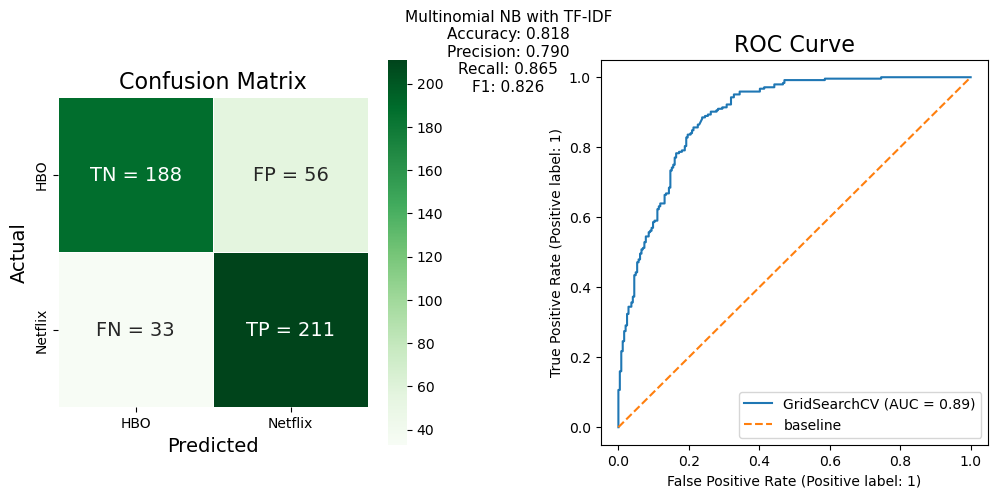

In [32]:
plot_cm_roc(gs_tfidf_nb, X_test, y_test, 'Multinomial NB with TF-IDF')

### Logistic Regression

#### Count Vectorizer

In [33]:
pipe_cvec_lr = Pipeline([('cvec3', CountVectorizer()),
                ('lr3', LogisticRegression())])

In [34]:
pipe_cvec_lr.get_params()

{'memory': None,
 'steps': [('cvec3', CountVectorizer()), ('lr3', LogisticRegression())],
 'verbose': False,
 'cvec3': CountVectorizer(),
 'lr3': LogisticRegression(),
 'cvec3__analyzer': 'word',
 'cvec3__binary': False,
 'cvec3__decode_error': 'strict',
 'cvec3__dtype': numpy.int64,
 'cvec3__encoding': 'utf-8',
 'cvec3__input': 'content',
 'cvec3__lowercase': True,
 'cvec3__max_df': 1.0,
 'cvec3__max_features': None,
 'cvec3__min_df': 1,
 'cvec3__ngram_range': (1, 1),
 'cvec3__preprocessor': None,
 'cvec3__stop_words': None,
 'cvec3__strip_accents': None,
 'cvec3__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec3__tokenizer': None,
 'cvec3__vocabulary': None,
 'lr3__C': 1.0,
 'lr3__class_weight': None,
 'lr3__dual': False,
 'lr3__fit_intercept': True,
 'lr3__intercept_scaling': 1,
 'lr3__l1_ratio': None,
 'lr3__max_iter': 100,
 'lr3__multi_class': 'auto',
 'lr3__n_jobs': None,
 'lr3__penalty': 'l2',
 'lr3__random_state': None,
 'lr3__solver': 'lbfgs',
 'lr3__tol': 0.0001,
 'lr3__verbose': 

In [35]:
pipe_cvec_lr_params = {
    'cvec3__max_features': [None],
    'cvec3__min_df': [1], 
    'cvec3__max_df': [0.1], 
    'cvec3__ngram_range': [(1,4)],
    'lr3__C': [0.1],
    'lr3__penalty': ['l2'],
    'lr3__solver': ['saga']} #['newton-cg', 'lbfgs', 'liblinear']}

In [36]:
gs_cvec_lr = GridSearchCV(pipe_cvec_lr, param_grid=pipe_cvec_lr_params, n_jobs=-1, cv=5)

In [37]:
gs_cvec_lr.fit(X_train, y_train)

/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec3', CountVectorizer()),
                                       ('lr3', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec3__max_df': [0.1], 'cvec3__max_features': [None],
                         'cvec3__min_df': [1], 'cvec3__ngram_range': [(1, 4)],
                         'lr3__C': [0.1], 'lr3__penalty': ['l2'],
                         'lr3__solver': ['saga']})

In [38]:
gs_cvec_lr.best_score_

0.7889288886810978

In [39]:
gs_cvec_lr.best_params_

{'cvec3__max_df': 0.1,
 'cvec3__max_features': None,
 'cvec3__min_df': 1,
 'cvec3__ngram_range': (1, 4),
 'lr3__C': 0.1,
 'lr3__penalty': 'l2',
 'lr3__solver': 'saga'}

In [41]:
gs_cvec_lr_train_score = gs_cvec_lr.score(X_train, y_train)
gs_cvec_lr_test_score = gs_cvec_lr.score(X_test, y_test)

print(f'Train Score: {gs_cvec_lr_train_score.round(3)}')
print(f'Test Score: {gs_cvec_lr_test_score.round(3)}')

Train Score: 0.99
Test Score: 0.799


In [42]:
y_pred_gs_cvec_lr = gs_cvec_lr.predict(X_test)

accuracy_gs_cvec_lr = accuracy_score(y_test, y_pred_gs_cvec_lr)
recall_gs_cvec_lr = recall_score(y_test, y_pred_gs_cvec_lr)
precision_gs_cvec_lr = precision_score(y_test, y_pred_gs_cvec_lr)
f1_gs_cvec_lr = f1_score(y_test, y_pred_gs_cvec_lr)

print(f'Prediction Accuracy: {accuracy_gs_cvec_lr.round(3)}\nPrediction Recall: {recall_gs_cvec_lr.round(3)}\nPrediction Precision: {precision_gs_cvec_lr.round(3)}\nPrediction F1: {f1_gs_cvec_lr.round(3)}')

Prediction Accuracy: 0.799
Prediction Recall: 0.873
Prediction Precision: 0.761
Prediction F1: 0.813


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


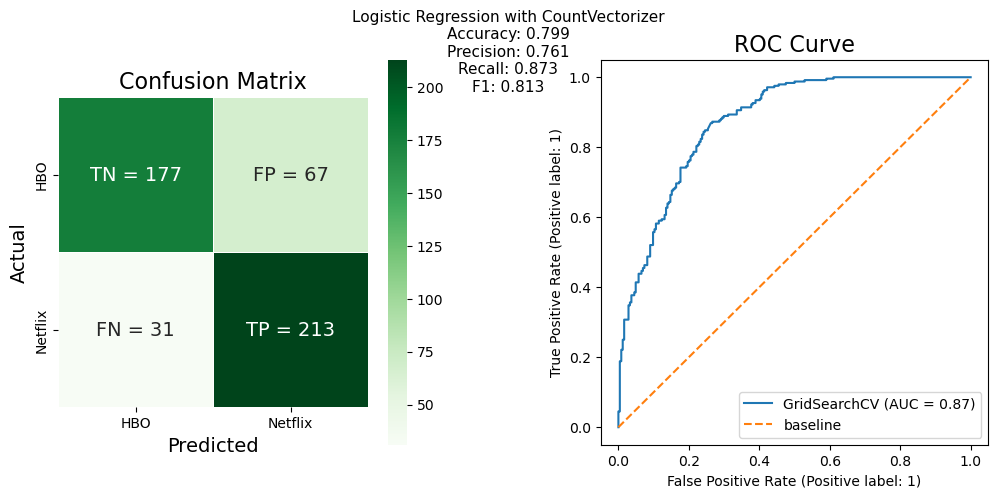

In [43]:
plot_cm_roc(gs_cvec_lr, X_test, y_test, 'Logistic Regression with CountVectorizer')

#### TF-IDF Vectorizer

In [44]:
pipe_tfidf_lr = Pipeline([('tfidf4', TfidfVectorizer()),
                ('lr4', LogisticRegression())])

In [45]:
pipe_tfidf_lr.get_params()

{'memory': None,
 'steps': [('tfidf4', TfidfVectorizer()), ('lr4', LogisticRegression())],
 'verbose': False,
 'tfidf4': TfidfVectorizer(),
 'lr4': LogisticRegression(),
 'tfidf4__analyzer': 'word',
 'tfidf4__binary': False,
 'tfidf4__decode_error': 'strict',
 'tfidf4__dtype': numpy.float64,
 'tfidf4__encoding': 'utf-8',
 'tfidf4__input': 'content',
 'tfidf4__lowercase': True,
 'tfidf4__max_df': 1.0,
 'tfidf4__max_features': None,
 'tfidf4__min_df': 1,
 'tfidf4__ngram_range': (1, 1),
 'tfidf4__norm': 'l2',
 'tfidf4__preprocessor': None,
 'tfidf4__smooth_idf': True,
 'tfidf4__stop_words': None,
 'tfidf4__strip_accents': None,
 'tfidf4__sublinear_tf': False,
 'tfidf4__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf4__tokenizer': None,
 'tfidf4__use_idf': True,
 'tfidf4__vocabulary': None,
 'lr4__C': 1.0,
 'lr4__class_weight': None,
 'lr4__dual': False,
 'lr4__fit_intercept': True,
 'lr4__intercept_scaling': 1,
 'lr4__l1_ratio': None,
 'lr4__max_iter': 100,
 'lr4__multi_class': 'auto',
 'lr4

In [46]:
pipe_tfidf_lr_params = {
    'tfidf4__max_features': [None],
    'tfidf4__min_df': [1],
    'tfidf4__max_df': [0.7],
    'tfidf4__ngram_range': [(1,2)],
    'lr4__C': [10000],
    'lr4__penalty': ['l2'],
    'lr4__solver': ['saga']} 

In [47]:
gs_tfidf_lr = GridSearchCV(pipe_tfidf_lr, param_grid=pipe_tfidf_lr_params, n_jobs=-1, cv=5)

In [48]:
gs_tfidf_lr.fit(X_train, y_train)

/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf4', TfidfVectorizer()),
                                       ('lr4', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr4__C': [10000], 'lr4__penalty': ['l2'],
                         'lr4__solver': ['saga'], 'tfidf4__max_df': [0.7],
                         'tfidf4__max_features': [None], 'tfidf4__min_df': [1],
                         'tfidf4__ngram_range': [(1, 2)]})

In [49]:
gs_tfidf_lr.best_score_

0.7718640422647155

In [50]:
gs_tfidf_lr.best_params_

{'lr4__C': 10000,
 'lr4__penalty': 'l2',
 'lr4__solver': 'saga',
 'tfidf4__max_df': 0.7,
 'tfidf4__max_features': None,
 'tfidf4__min_df': 1,
 'tfidf4__ngram_range': (1, 2)}

In [52]:
gs_tfidf_lr_train_score = gs_tfidf_lr.score(X_train, y_train)
gs_tfidf_lr_test_score = gs_tfidf_lr.score(X_test, y_test)

print(f'Train Score: {gs_tfidf_lr_train_score.round(3)}')
print(f'Test Score: {gs_tfidf_lr_test_score.round(3)}')

Train Score: 0.999
Test Score: 0.811


In [53]:
y_pred_gs_tfidf_lr = gs_tfidf_lr.predict(X_test)

accuracy_gs_tfidf_lr = accuracy_score(y_test, y_pred_gs_tfidf_lr)
recall_gs_tfidf_lr = recall_score(y_test, y_pred_gs_tfidf_lr)
precision_gs_tfidf_lr = precision_score(y_test, y_pred_gs_tfidf_lr)
f1_gs_tfidf_lr = f1_score(y_test, y_pred_gs_tfidf_lr)

print(f'Prediction Accuracy: {accuracy_gs_tfidf_lr.round(3)}\nPrediction Recall: {recall_gs_tfidf_lr.round(3)}\nPrediction Precision: {precision_gs_tfidf_lr.round(3)}\nPrediction F1: {f1_gs_tfidf_lr.round(3)}')

Prediction Accuracy: 0.811
Prediction Recall: 0.881
Prediction Precision: 0.773
Prediction F1: 0.824


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


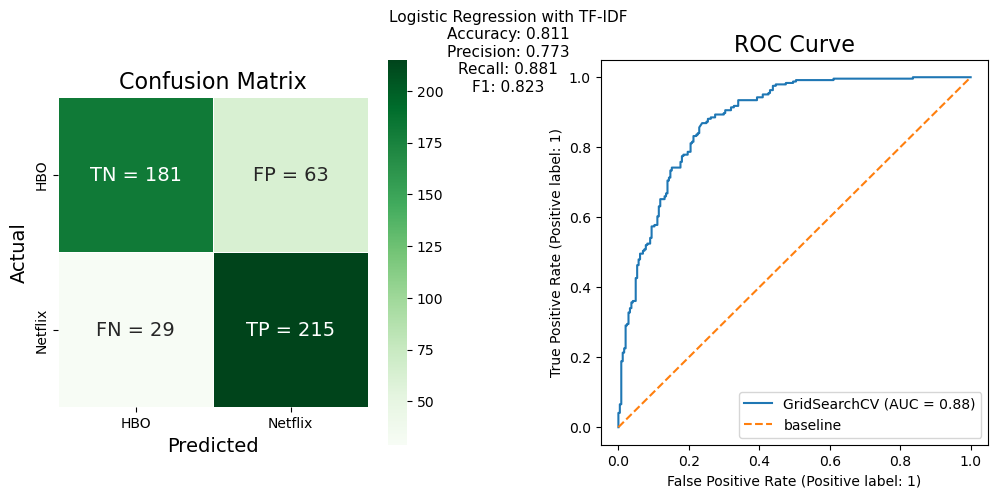

In [54]:
plot_cm_roc(gs_tfidf_lr, X_test, y_test, 'Logistic Regression with TF-IDF')

### Random Forest

#### Count Vectorizer

In [55]:
pipe_cvec_rf = Pipeline([('cvec7', CountVectorizer()),
                ('rf7', RandomForestClassifier())])

In [56]:
pipe_cvec_rf.get_params()

{'memory': None,
 'steps': [('cvec7', CountVectorizer()), ('rf7', RandomForestClassifier())],
 'verbose': False,
 'cvec7': CountVectorizer(),
 'rf7': RandomForestClassifier(),
 'cvec7__analyzer': 'word',
 'cvec7__binary': False,
 'cvec7__decode_error': 'strict',
 'cvec7__dtype': numpy.int64,
 'cvec7__encoding': 'utf-8',
 'cvec7__input': 'content',
 'cvec7__lowercase': True,
 'cvec7__max_df': 1.0,
 'cvec7__max_features': None,
 'cvec7__min_df': 1,
 'cvec7__ngram_range': (1, 1),
 'cvec7__preprocessor': None,
 'cvec7__stop_words': None,
 'cvec7__strip_accents': None,
 'cvec7__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec7__tokenizer': None,
 'cvec7__vocabulary': None,
 'rf7__bootstrap': True,
 'rf7__ccp_alpha': 0.0,
 'rf7__class_weight': None,
 'rf7__criterion': 'gini',
 'rf7__max_depth': None,
 'rf7__max_features': 'auto',
 'rf7__max_leaf_nodes': None,
 'rf7__max_samples': None,
 'rf7__min_impurity_decrease': 0.0,
 'rf7__min_samples_leaf': 1,
 'rf7__min_samples_split': 2,
 'rf7__min_weight

In [57]:
pipe_cvec_rf_params = {
    'cvec7__max_features': [None], 
    'cvec7__min_df': [1], 
    'cvec7__max_df': [0.5], 
    'cvec7__ngram_range': [(1,2)], 
    'rf7__max_depth' : [16], 
    'rf7__n_estimators': [1200],
    'rf7__max_leaf_nodes': [32],
    'rf7__min_samples_split': [2],
    'rf7__min_samples_leaf': [2],
    'rf7__class_weight': ['balanced']}

In [58]:
gs_cvec_rf = GridSearchCV(pipe_cvec_rf, param_grid=pipe_cvec_rf_params, n_jobs=-1, cv=5)

In [59]:
gs_cvec_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec7', CountVectorizer()),
                                       ('rf7', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec7__max_df': [0.5], 'cvec7__max_features': [None],
                         'cvec7__min_df': [1], 'cvec7__ngram_range': [(1, 2)],
                         'rf7__class_weight': ['balanced'],
                         'rf7__max_depth': [16], 'rf7__max_leaf_nodes': [32],
                         'rf7__min_samples_leaf': [2],
                         'rf7__min_samples_split': [2],
                         'rf7__n_estimators': [1200]})

In [60]:
gs_cvec_rf.best_score_

0.7575038571228202

In [61]:
gs_cvec_rf.best_params_

{'cvec7__max_df': 0.5,
 'cvec7__max_features': None,
 'cvec7__min_df': 1,
 'cvec7__ngram_range': (1, 2),
 'rf7__class_weight': 'balanced',
 'rf7__max_depth': 16,
 'rf7__max_leaf_nodes': 32,
 'rf7__min_samples_leaf': 2,
 'rf7__min_samples_split': 2,
 'rf7__n_estimators': 1200}

In [62]:
gs_cvec_rf.best_estimator_[0].get_feature_names_out()
impt_df = pd.DataFrame(gs_cvec_rf.best_estimator_[1].feature_importances_, index = gs_cvec_rf.best_estimator_[0].get_feature_names_out())
impt_df.columns = ['importance']
impt_df.sort_values(by = ['importance'], ascending = False).head(10)

,importance
last us,0.044156
us,0.039065
max,0.027220
last,0.026457
account,0.021709
white,0.014237
euphoria,0.013820
wire,0.013431
westworld,0.012389
succession,0.011491


In [63]:
gs_cvec_rf.best_estimator_[0].get_feature_names_out()

array(['aa', 'aa old', 'aaron', ..., 'zoom zoom', 'zulfiqar',
       'zulfiqar ali'], dtype=object)

In [64]:
impt_df7 = pd.DataFrame(gs_cvec_rf.best_estimator_[1].feature_importances_, index = gs_cvec_rf.best_estimator_[0].get_feature_names_out())

In [65]:
impt_df7.columns = ['importance']

In [66]:
impt_df7.sort_values(by = ['importance'], ascending = False).head(10)

,importance
last us,0.044156
us,0.039065
max,0.027220
last,0.026457
account,0.021709
white,0.014237
euphoria,0.013820
wire,0.013431
westworld,0.012389
succession,0.011491


In [67]:
gs_cvec_rf_train_score = gs_cvec_rf.score(X_train, y_train)
gs_cvec_rf_test_score = gs_cvec_rf.score(X_test, y_test)

print(f'Train Score: {gs_cvec_rf_train_score.round(3)}')
print(f'Test Score: {gs_cvec_rf_test_score.round(3)}')

Train Score: 0.849
Test Score: 0.756


In [68]:
y_pred_gs_cvec_rf = gs_cvec_rf.predict(X_test)

accuracy_gs_cvec_rf = accuracy_score(y_test, y_pred_gs_cvec_rf)
recall_gs_cvec_rf = recall_score(y_test, y_pred_gs_cvec_rf)
precision_gs_cvec_rf = precision_score(y_test, y_pred_gs_cvec_rf)
f1_gs_cvec_rf = f1_score(y_test, y_pred_gs_cvec_rf)

print(f'Prediction Accuracy: {accuracy_gs_cvec_rf.round(3)}\nPrediction Recall: {recall_gs_cvec_rf.round(3)}\nPrediction Precision: {precision_gs_cvec_rf.round(3)}\nPrediction F1: {f1_gs_cvec_rf.round(3)}')

Prediction Accuracy: 0.756
Prediction Recall: 0.734
Prediction Precision: 0.768
Prediction F1: 0.751


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


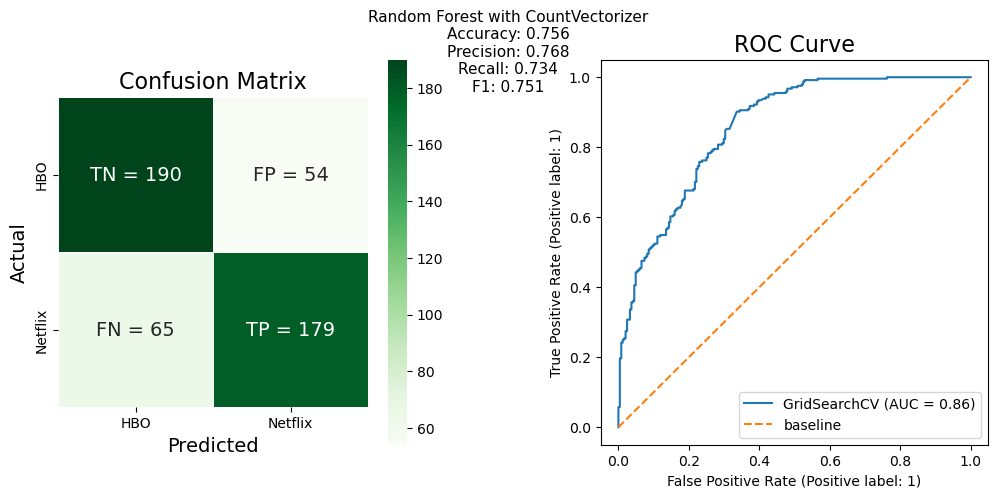

In [69]:
plot_cm_roc(gs_cvec_rf, X_test, y_test, 'Random Forest with CountVectorizer')

#### TF-IDF Vectorizer

In [70]:
pipe_tfidf_rf = Pipeline([('tfidf8', TfidfVectorizer()),
                ('rf8', RandomForestClassifier())])

In [71]:
pipe_tfidf_rf.get_params()

{'memory': None,
 'steps': [('tfidf8', TfidfVectorizer()), ('rf8', RandomForestClassifier())],
 'verbose': False,
 'tfidf8': TfidfVectorizer(),
 'rf8': RandomForestClassifier(),
 'tfidf8__analyzer': 'word',
 'tfidf8__binary': False,
 'tfidf8__decode_error': 'strict',
 'tfidf8__dtype': numpy.float64,
 'tfidf8__encoding': 'utf-8',
 'tfidf8__input': 'content',
 'tfidf8__lowercase': True,
 'tfidf8__max_df': 1.0,
 'tfidf8__max_features': None,
 'tfidf8__min_df': 1,
 'tfidf8__ngram_range': (1, 1),
 'tfidf8__norm': 'l2',
 'tfidf8__preprocessor': None,
 'tfidf8__smooth_idf': True,
 'tfidf8__stop_words': None,
 'tfidf8__strip_accents': None,
 'tfidf8__sublinear_tf': False,
 'tfidf8__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf8__tokenizer': None,
 'tfidf8__use_idf': True,
 'tfidf8__vocabulary': None,
 'rf8__bootstrap': True,
 'rf8__ccp_alpha': 0.0,
 'rf8__class_weight': None,
 'rf8__criterion': 'gini',
 'rf8__max_depth': None,
 'rf8__max_features': 'auto',
 'rf8__max_leaf_nodes': None,
 'rf8__m

In [72]:
pipe_tfidf_rf_params = {
    'tfidf8__max_features': [700, 800, 1000],
    'tfidf8__min_df': [2], 
    'tfidf8__max_df': [0.3], 
    'rf8__max_depth' : [32],
    'tfidf8__ngram_range': [(1,2)],  
    'rf8__n_estimators': [800],
    'rf8__max_leaf_nodes': [None],
    'rf8__min_samples_split': [3],
    'rf8__min_samples_leaf': [1],
    'rf8__class_weight': [None] }

In [73]:
gs_tfidf_rf = GridSearchCV(pipe_tfidf_rf, param_grid=pipe_tfidf_rf_params, n_jobs=-1, cv=5)

In [74]:
gs_tfidf_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf8', TfidfVectorizer()),
                                       ('rf8', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf8__class_weight': [None], 'rf8__max_depth': [32],
                         'rf8__max_leaf_nodes': [None],
                         'rf8__min_samples_leaf': [1],
                         'rf8__min_samples_split': [3],
                         'rf8__n_estimators': [800], 'tfidf8__max_df': [0.3],
                         'tfidf8__max_features': [700, 800, 1000],
                         'tfidf8__min_df': [2],
                         'tfidf8__ngram_range': [(1, 2)]})

In [75]:
gs_tfidf_rf.best_score_

0.7472696245733788

In [76]:
gs_tfidf_rf.best_params_

{'rf8__class_weight': None,
 'rf8__max_depth': 32,
 'rf8__max_leaf_nodes': None,
 'rf8__min_samples_leaf': 1,
 'rf8__min_samples_split': 3,
 'rf8__n_estimators': 800,
 'tfidf8__max_df': 0.3,
 'tfidf8__max_features': 1000,
 'tfidf8__min_df': 2,
 'tfidf8__ngram_range': (1, 2)}

In [77]:
gs_tfidf_rf.best_estimator_[0].get_feature_names_out()
impt_df8 = pd.DataFrame(gs_tfidf_rf.best_estimator_[1].feature_importances_, index = gs_tfidf_rf.best_estimator_[0].get_feature_names_out())
impt_df8.columns = ['importance']
impt_df8.sort_values(by = ['importance'], ascending = False).head(10)

,importance
max,0.069612
us,0.062104
last us,0.056297
last,0.045286
wire,0.029587
account,0.028482
euphoria,0.026742
white,0.019671
westworld,0.018941
succession,0.018143


In [78]:
gs_tfidf_rf_train_score = gs_tfidf_rf.score(X_train, y_train)
gs_tfidf_rf_test_score = gs_tfidf_rf.score(X_test, y_test)

print(f'Train Score: {gs_tfidf_rf_train_score.round(3)}')
print(f'Test Score: {gs_tfidf_rf_test_score.round(3)}')

Train Score: 0.831
Test Score: 0.732


In [79]:
y_pred_gs_tfidf_rf = gs_tfidf_rf.predict(X_test)

accuracy_gs_tfidf_rf = accuracy_score(y_test, y_pred_gs_tfidf_rf)
recall_gs_tfidf_rf = recall_score(y_test, y_pred_gs_tfidf_rf)
precision_gs_tfidf_rf = precision_score(y_test, y_pred_gs_tfidf_rf)
f1_gs_tfidf_rf = f1_score(y_test, y_pred_gs_tfidf_rf)

print(f'Prediction Accuracy: {accuracy_gs_tfidf_rf.round(3)}\nPrediction Recall: {recall_gs_tfidf_rf.round(3)}\nPrediction Precision: {precision_gs_tfidf_rf.round(3)}\nPrediction F1: {f1_gs_tfidf_rf.round(3)}')

Prediction Accuracy: 0.732
Prediction Recall: 0.963
Prediction Precision: 0.658
Prediction F1: 0.782


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


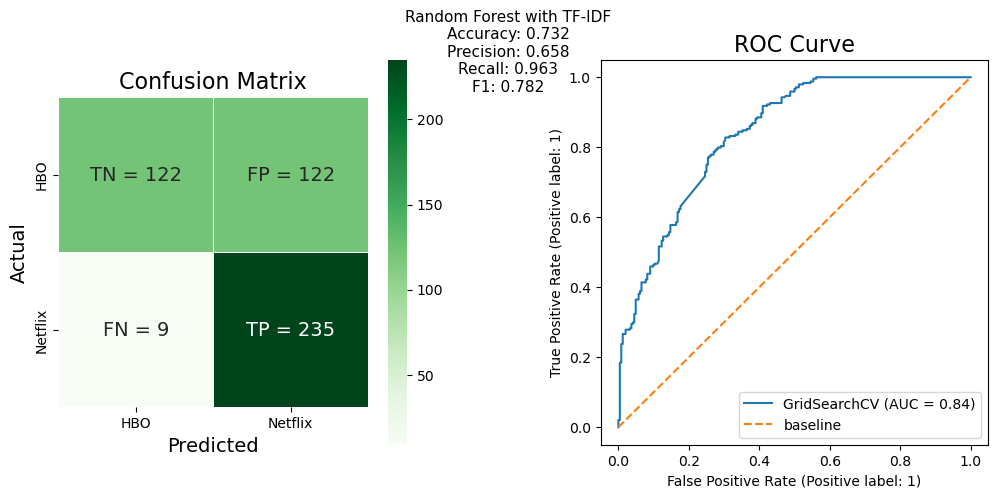

In [80]:
plot_cm_roc(gs_tfidf_rf, X_test, y_test, 'Random Forest with TF-IDF')

### Gradient Boosting

#### Count Vectorizer

In [81]:
# Set up pipeline for GridSearchCV, CountVectorizer and GradientBoostingClassifier
pipe_cvec_gb = Pipeline([('cvec9', CountVectorizer()),
                ('gb9', GradientBoostingClassifier())])

In [82]:
pipe_cvec_gb.get_params()

{'memory': None,
 'steps': [('cvec9', CountVectorizer()),
  ('gb9', GradientBoostingClassifier())],
 'verbose': False,
 'cvec9': CountVectorizer(),
 'gb9': GradientBoostingClassifier(),
 'cvec9__analyzer': 'word',
 'cvec9__binary': False,
 'cvec9__decode_error': 'strict',
 'cvec9__dtype': numpy.int64,
 'cvec9__encoding': 'utf-8',
 'cvec9__input': 'content',
 'cvec9__lowercase': True,
 'cvec9__max_df': 1.0,
 'cvec9__max_features': None,
 'cvec9__min_df': 1,
 'cvec9__ngram_range': (1, 1),
 'cvec9__preprocessor': None,
 'cvec9__stop_words': None,
 'cvec9__strip_accents': None,
 'cvec9__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec9__tokenizer': None,
 'cvec9__vocabulary': None,
 'gb9__ccp_alpha': 0.0,
 'gb9__criterion': 'friedman_mse',
 'gb9__init': None,
 'gb9__learning_rate': 0.1,
 'gb9__loss': 'deviance',
 'gb9__max_depth': 3,
 'gb9__max_features': None,
 'gb9__max_leaf_nodes': None,
 'gb9__min_impurity_decrease': 0.0,
 'gb9__min_samples_leaf': 1,
 'gb9__min_samples_split': 2,
 'gb9__min

In [83]:
pipe_cvec_gb_params = {
    'cvec9__max_features': [None],
    'cvec9__min_df': [1],
    'cvec9__max_df': [0.8],
    'cvec9__ngram_range': [(1,1)],
    'gb9__max_depth' : [6],
    'gb9__subsample' : [0.8],
    'gb9__learning_rate': [0.1],
    'gb9__n_estimators': [100]}

In [84]:
gs_cvec_gb = GridSearchCV(pipe_cvec_gb, param_grid=pipe_cvec_gb_params, n_jobs=1, cv=5)

In [85]:
gs_cvec_gb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec9', CountVectorizer()),
                                       ('gb9', GradientBoostingClassifier())]),
             n_jobs=1,
             param_grid={'cvec9__max_df': [0.8], 'cvec9__max_features': [None],
                         'cvec9__min_df': [1], 'cvec9__ngram_range': [(1, 1)],
                         'gb9__learning_rate': [0.1], 'gb9__max_depth': [6],
                         'gb9__n_estimators': [100], 'gb9__subsample': [0.8]})

In [86]:
gs_cvec_gb.best_score_

0.7629809715274207

In [87]:
gs_cvec_gb.best_params_

{'cvec9__max_df': 0.8,
 'cvec9__max_features': None,
 'cvec9__min_df': 1,
 'cvec9__ngram_range': (1, 1),
 'gb9__learning_rate': 0.1,
 'gb9__max_depth': 6,
 'gb9__n_estimators': 100,
 'gb9__subsample': 0.8}

In [88]:
gs_cvec_gb.best_estimator_[0].get_feature_names_out()
impt_df9 = pd.DataFrame(gs_cvec_gb.best_estimator_[1].feature_importances_, index = gs_cvec_gb.best_estimator_[0].get_feature_names_out())
impt_df9.columns = ['importance']
impt_df9.sort_values(by = ['importance'], ascending = False).head(10)

,importance
us,0.126240
max,0.066671
white,0.038057
wire,0.036957
account,0.031719
euphoria,0.031342
westworld,0.021188
succession,0.020365
throne,0.013731
work,0.011692


In [89]:
gs_cvec_gb_train_score = gs_cvec_gb.score(X_train, y_train)
gs_cvec_gb_test_score = gs_cvec_gb.score(X_test, y_test)

print(f'Train Score: {gs_cvec_gb_train_score.round(3)}')
print(f'Test Score: {gs_cvec_gb_test_score.round(3)}')

Train Score: 0.895
Test Score: 0.76


In [90]:
y_pred_gs_cvec_gb = gs_cvec_gb.predict(X_test)

accuracy_gs_cvec_gb = accuracy_score(y_test, y_pred_gs_cvec_gb)
recall_gs_cvec_gb = recall_score(y_test, y_pred_gs_cvec_gb)
precision_gs_cvec_gb = precision_score(y_test, y_pred_gs_cvec_gb)
f1_gs_cvec_gb = f1_score(y_test, y_pred_gs_cvec_gb)

print(f'Prediction Accuracy: {accuracy_gs_cvec_gb.round(3)}\nPrediction Recall: {recall_gs_cvec_gb.round(3)}\nPrediction Precision: {precision_gs_cvec_gb.round(3)}\nPrediction F1: {f1_gs_cvec_gb.round(3)}')

Prediction Accuracy: 0.76
Prediction Recall: 0.922
Prediction Precision: 0.697
Prediction F1: 0.794


#### TF-IDF Vectorizer

In [91]:
# Set up pipeline for GridSearchCV, TF-IDF and GradientBoostingClassifier
pipe_tfidf_gb = Pipeline([('tfidf10', TfidfVectorizer()),
                ('gb10', GradientBoostingClassifier())])

In [92]:
pipe_tfidf_gb.get_params()

{'memory': None,
 'steps': [('tfidf10', TfidfVectorizer()),
  ('gb10', GradientBoostingClassifier())],
 'verbose': False,
 'tfidf10': TfidfVectorizer(),
 'gb10': GradientBoostingClassifier(),
 'tfidf10__analyzer': 'word',
 'tfidf10__binary': False,
 'tfidf10__decode_error': 'strict',
 'tfidf10__dtype': numpy.float64,
 'tfidf10__encoding': 'utf-8',
 'tfidf10__input': 'content',
 'tfidf10__lowercase': True,
 'tfidf10__max_df': 1.0,
 'tfidf10__max_features': None,
 'tfidf10__min_df': 1,
 'tfidf10__ngram_range': (1, 1),
 'tfidf10__norm': 'l2',
 'tfidf10__preprocessor': None,
 'tfidf10__smooth_idf': True,
 'tfidf10__stop_words': None,
 'tfidf10__strip_accents': None,
 'tfidf10__sublinear_tf': False,
 'tfidf10__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf10__tokenizer': None,
 'tfidf10__use_idf': True,
 'tfidf10__vocabulary': None,
 'gb10__ccp_alpha': 0.0,
 'gb10__criterion': 'friedman_mse',
 'gb10__init': None,
 'gb10__learning_rate': 0.1,
 'gb10__loss': 'deviance',
 'gb10__max_depth': 3,
 

In [93]:
pipe_tfidf_gb_get_params = {
    'tfidf10__max_features': [None],
    'tfidf10__min_df': [1, 2],
    'tfidf10__max_df': [0.9],
    'gb10__max_depth' : [10],
    'gb10__subsample' : [0.8],
    'gb10__learning_rate': [0.1],
    'tfidf10__ngram_range': [(1,3)],
    'gb10__n_estimators': [50, 30]}

In [94]:
gs_tfidf_gb = GridSearchCV(pipe_tfidf_gb, param_grid=pipe_tfidf_gb_get_params, n_jobs=-1, cv=5)

In [95]:
gs_tfidf_gb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf10', TfidfVectorizer()),
                                       ('gb10', GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gb10__learning_rate': [0.1], 'gb10__max_depth': [10],
                         'gb10__n_estimators': [50, 30],
                         'gb10__subsample': [0.8], 'tfidf10__max_df': [0.9],
                         'tfidf10__max_features': [None],
                         'tfidf10__min_df': [1, 2],
                         'tfidf10__ngram_range': [(1, 3)]})

In [96]:
gs_tfidf_gb.best_score_

0.7561456823600916

In [97]:
gs_tfidf_gb.best_params_

{'gb10__learning_rate': 0.1,
 'gb10__max_depth': 10,
 'gb10__n_estimators': 50,
 'gb10__subsample': 0.8,
 'tfidf10__max_df': 0.9,
 'tfidf10__max_features': None,
 'tfidf10__min_df': 2,
 'tfidf10__ngram_range': (1, 3)}

In [98]:
gs_tfidf_gb.best_estimator_[0].get_feature_names_out()
impt_df10 = pd.DataFrame(gs_tfidf_gb.best_estimator_[1].feature_importances_, index = gs_tfidf_gb.best_estimator_[0].get_feature_names_out())
impt_df10.columns = ['importance']
impt_df10.sort_values(by = ['importance'], ascending = False).head(10)

,importance
us,0.129341
max,0.080730
white,0.044545
wire,0.039247
euphoria,0.034681
account,0.030203
westworld,0.024509
succession,0.018334
air,0.017610
throne,0.014763


In [99]:
gs_tfidf_gb_train_score = gs_tfidf_gb.score(X_train, y_train)
gs_tfidf_gb_test_score = gs_tfidf_gb.score(X_test, y_test)

print(f'Train Score: {gs_tfidf_gb_train_score.round(3)}')
print(f'Test Score: {gs_tfidf_gb_test_score.round(3)}')

Train Score: 0.891
Test Score: 0.734


In [100]:
y_pred_gs_tfidf_gb = gs_tfidf_gb.predict(X_test)

accuracy_gs_tfidf_gb = accuracy_score(y_test, y_pred_gs_tfidf_gb)
recall_gs_tfidf_gb = recall_score(y_test, y_pred_gs_tfidf_gb)
precision_gs_tfidf_gb = precision_score(y_test, y_pred_gs_tfidf_gb)
f1_gs_tfidf_gb = f1_score(y_test, y_pred_gs_tfidf_gb)

print(f'Prediction Accuracy: {accuracy_gs_tfidf_gb.round(3)}\nPrediction Recall: {recall_gs_tfidf_gb.round(3)}\nPrediction Precision: {precision_gs_tfidf_gb.round(3)}\nPrediction F1: {f1_gs_tfidf_gb.round(3)}')

Prediction Accuracy: 0.734
Prediction Recall: 0.881
Prediction Precision: 0.68
Prediction F1: 0.768


### Linear SVC

#### CountVectorizer

In [101]:
# Set up pipeline for GridSearchCV, CountVectorizer and Linear SVC
pipe_cvec_svc = Pipeline([('cvec11', CountVectorizer()),
                            ('svc11', LinearSVC())])

In [102]:
pipe_cvec_svc.get_params()

{'memory': None,
 'steps': [('cvec11', CountVectorizer()), ('svc11', LinearSVC())],
 'verbose': False,
 'cvec11': CountVectorizer(),
 'svc11': LinearSVC(),
 'cvec11__analyzer': 'word',
 'cvec11__binary': False,
 'cvec11__decode_error': 'strict',
 'cvec11__dtype': numpy.int64,
 'cvec11__encoding': 'utf-8',
 'cvec11__input': 'content',
 'cvec11__lowercase': True,
 'cvec11__max_df': 1.0,
 'cvec11__max_features': None,
 'cvec11__min_df': 1,
 'cvec11__ngram_range': (1, 1),
 'cvec11__preprocessor': None,
 'cvec11__stop_words': None,
 'cvec11__strip_accents': None,
 'cvec11__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec11__tokenizer': None,
 'cvec11__vocabulary': None,
 'svc11__C': 1.0,
 'svc11__class_weight': None,
 'svc11__dual': True,
 'svc11__fit_intercept': True,
 'svc11__intercept_scaling': 1,
 'svc11__loss': 'squared_hinge',
 'svc11__max_iter': 1000,
 'svc11__multi_class': 'ovr',
 'svc11__penalty': 'l2',
 'svc11__random_state': None,
 'svc11__tol': 0.0001,
 'svc11__verbose': 0}

In [103]:
pipe_cvec_svc_params = {
    'svc11__penalty': ['l2'],
    'svc11__C': [0.01],
    'svc11__class_weight': [None],
    'svc11__max_iter': [1000],
    'svc11__loss': ['squared_hinge'],
    'cvec11__max_features': [None],
    'cvec11__min_df': [2],
    'cvec11__max_df': [0.1],
    'cvec11__ngram_range': [(1,2)]}

In [104]:
gs_cvec_svc = GridSearchCV(pipe_cvec_svc, param_grid=pipe_cvec_svc_params, n_jobs=-1, cv=5)

In [105]:
gs_cvec_svc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec11', CountVectorizer()),
                                       ('svc11', LinearSVC())]),
             n_jobs=-1,
             param_grid={'cvec11__max_df': [0.1],
                         'cvec11__max_features': [None], 'cvec11__min_df': [2],
                         'cvec11__ngram_range': [(1, 2)], 'svc11__C': [0.01],
                         'svc11__class_weight': [None],
                         'svc11__loss': ['squared_hinge'],
                         'svc11__max_iter': [1000], 'svc11__penalty': ['l2']})

In [106]:
gs_cvec_svc.best_score_

0.768453410631633

In [108]:
gs_cvec_svc.best_params_

{'cvec11__max_df': 0.1,
 'cvec11__max_features': None,
 'cvec11__min_df': 2,
 'cvec11__ngram_range': (1, 2),
 'svc11__C': 0.01,
 'svc11__class_weight': None,
 'svc11__loss': 'squared_hinge',
 'svc11__max_iter': 1000,
 'svc11__penalty': 'l2'}

In [109]:
gs_cvec_svc_train_score = gs_cvec_svc.score(X_train, y_train)
gs_cvec_svc_test_score = gs_cvec_svc.score(X_test, y_test)

print(f'Train Score: {gs_cvec_svc_train_score.round(3)}')
print(f'Test Score: {gs_cvec_svc_test_score.round(3)}')

Train Score: 0.92
Test Score: 0.77


In [110]:
y_pred_gs_cvec_svc = gs_cvec_svc.predict(X_test)

accuracy_gs_cvec_svc = accuracy_score(y_test, y_pred_gs_cvec_svc)
recall_gs_cvec_svc = recall_score(y_test, y_pred_gs_cvec_svc)
precision_gs_cvec_svc = precision_score(y_test, y_pred_gs_cvec_svc)
f1_gs_cvec_svc = f1_score(y_test, y_pred_gs_cvec_svc)

print(f'Prediction Accuracy: {accuracy_gs_cvec_svc.round(3)}\nPrediction Recall: {recall_gs_cvec_svc.round(3)}\nPrediction Precision: {precision_gs_cvec_svc.round(3)}\nPrediction F1: {f1_gs_cvec_svc.round(3)}')

Prediction Accuracy: 0.77
Prediction Recall: 0.861
Prediction Precision: 0.729
Prediction F1: 0.789


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


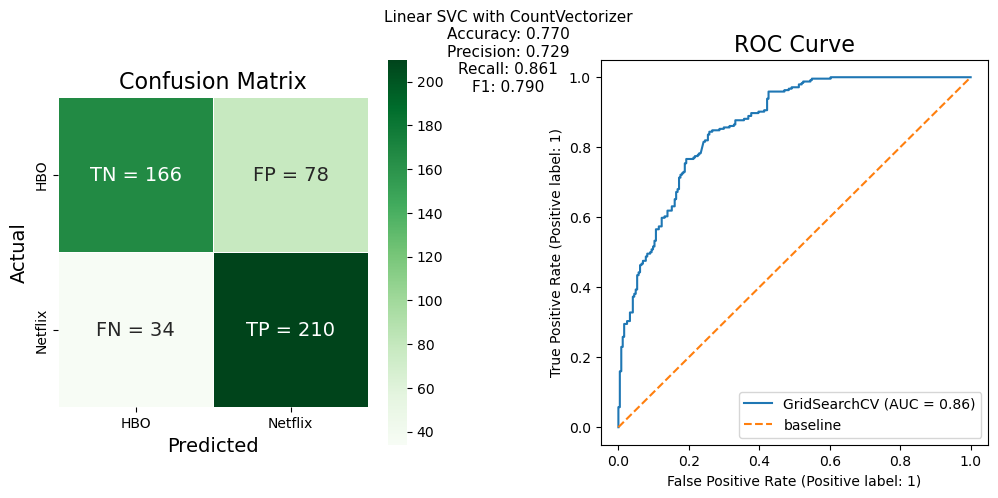

In [111]:
plot_cm_roc(gs_cvec_svc, X_test, y_test, 'Linear SVC with CountVectorizer')

#### TF-IDF Vectorizer

In [112]:
# Set up pipeline for GridSearchCV, TF-IDF and Linear SVC
pipe_tfidf_svc = Pipeline([('tfidf12', TfidfVectorizer()),
                            ('svc12', LinearSVC())])

In [113]:
pipe_tfidf_svc.get_params()

{'memory': None,
 'steps': [('tfidf12', TfidfVectorizer()), ('svc12', LinearSVC())],
 'verbose': False,
 'tfidf12': TfidfVectorizer(),
 'svc12': LinearSVC(),
 'tfidf12__analyzer': 'word',
 'tfidf12__binary': False,
 'tfidf12__decode_error': 'strict',
 'tfidf12__dtype': numpy.float64,
 'tfidf12__encoding': 'utf-8',
 'tfidf12__input': 'content',
 'tfidf12__lowercase': True,
 'tfidf12__max_df': 1.0,
 'tfidf12__max_features': None,
 'tfidf12__min_df': 1,
 'tfidf12__ngram_range': (1, 1),
 'tfidf12__norm': 'l2',
 'tfidf12__preprocessor': None,
 'tfidf12__smooth_idf': True,
 'tfidf12__stop_words': None,
 'tfidf12__strip_accents': None,
 'tfidf12__sublinear_tf': False,
 'tfidf12__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf12__tokenizer': None,
 'tfidf12__use_idf': True,
 'tfidf12__vocabulary': None,
 'svc12__C': 1.0,
 'svc12__class_weight': None,
 'svc12__dual': True,
 'svc12__fit_intercept': True,
 'svc12__intercept_scaling': 1,
 'svc12__loss': 'squared_hinge',
 'svc12__max_iter': 1000,
 'sv

In [114]:
pipe_tfidf_svc_params = {
    'svc12__penalty': ['l2'],
    'svc12__C': [0.01, 1],
    'svc12__class_weight': [None],
    'svc12__max_iter': [500],
    'svc12__loss': ['squared_hinge'],
    'tfidf12__max_features': [None],
    'tfidf12__min_df': [1, 2],
    'tfidf12__max_df': [0.5, 0.7],
    'tfidf12__ngram_range': [(1,1), (1,3)]}

In [115]:
gs_tfidf_svc = GridSearchCV(pipe_tfidf_svc, param_grid=pipe_tfidf_svc_params, n_jobs=-1, cv=5)

In [116]:
gs_tfidf_svc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf12', TfidfVectorizer()),
                                       ('svc12', LinearSVC())]),
             n_jobs=-1,
             param_grid={'svc12__C': [0.01, 1], 'svc12__class_weight': [None],
                         'svc12__loss': ['squared_hinge'],
                         'svc12__max_iter': [500], 'svc12__penalty': ['l2'],
                         'tfidf12__max_df': [0.5, 0.7],
                         'tfidf12__max_features': [None],
                         'tfidf12__min_df': [1, 2],
                         'tfidf12__ngram_range': [(1, 1), (1, 3)]})

In [117]:
gs_tfidf_svc.best_score_

0.780052830894385

In [118]:
gs_tfidf_svc.best_params_

{'svc12__C': 1,
 'svc12__class_weight': None,
 'svc12__loss': 'squared_hinge',
 'svc12__max_iter': 500,
 'svc12__penalty': 'l2',
 'tfidf12__max_df': 0.5,
 'tfidf12__max_features': None,
 'tfidf12__min_df': 1,
 'tfidf12__ngram_range': (1, 3)}

In [120]:
gs_tfidf_svc_train_score = gs_tfidf_svc.score(X_train, y_train)
gs_tfidf_svc_test_score = gs_tfidf_svc.score(X_test, y_test)

print(f'Train Score: {gs_tfidf_svc_train_score.round(3)}')
print(f'Test Score: {gs_tfidf_svc_test_score.round(3)}')

Train Score: 0.999
Test Score: 0.809


In [121]:
y_pred_gs_tfidf_svc = gs_tfidf_svc.predict(X_test)

accuracy_gs_tfidf_svc = accuracy_score(y_test, y_pred_gs_tfidf_svc)
recall_gs_tfidf_svc = recall_score(y_test, y_pred_gs_tfidf_svc)
precision_gs_tfidf_svc = precision_score(y_test, y_pred_gs_tfidf_svc)
f1_gs_tfidf_svc = f1_score(y_test, y_pred_gs_tfidf_svc)

print(f'Prediction Accuracy: {accuracy_gs_tfidf_svc.round(3)}\nPrediction Recall: {recall_gs_tfidf_svc.round(3)}\nPrediction Precision: {precision_gs_tfidf_svc.round(3)}\nPrediction F1: {f1_gs_tfidf_svc.round(3)}')

Prediction Accuracy: 0.809
Prediction Recall: 0.898
Prediction Precision: 0.763
Prediction F1: 0.825


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


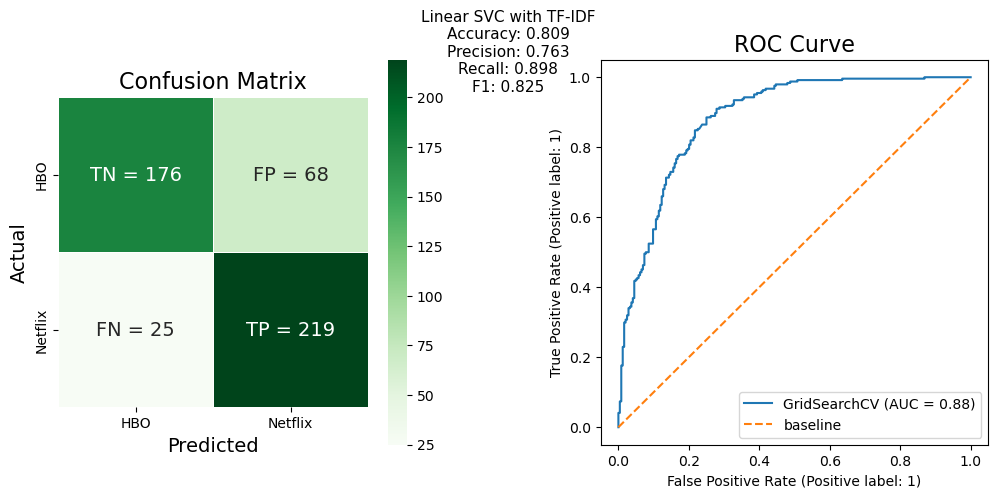

In [122]:
plot_cm_roc(gs_tfidf_svc, X_test, y_test, 'Linear SVC with TF-IDF')

### Model results (in %)

|Model|Best Score|Train Score|Test Score|
|---|---|---|---|
|Multinomial NB CV (Before)|-|94.8|78.4|
|Multinomial NB CV (After)|78.1|99.6|80.3|
|Multinomial TF-IDF (Before)|-|95.7|80.2|
|Multinomial TF-IDF (After)|80.0|99.9|81.8|
|Logistic Regression CV (Before)|-|99.3|77.6|
|Logistic Regression CV (After)|78.9|99.0|79.9|
|Logistic Regression TF-IDF (Before)|-|96.4|78.0|
|Logistic Regression TF-IDF (After)|77.2|99.9|81.1|
|Random Forest CV (Before)|-|99.9|75.7|
|Random Forest CV (After)|75.8|84.9|75.6|
|Random Forest TF-IDF (Before)|-|99.9|76.9|
|Random Forest TF-IDF (After)|74.7|83.1|73.2|
|Gradient Boosting CV (Before)|-|81.5|75.1|
|Gradient Boosting CV (After)|76.3|89.5|76.0|
|Gradient Boosting TF-IDF (Before)|-|83.2|75.5|
|Gradient Boosting TF-IDF (After)|75.6|89.1|73.4|
|Linear SVC CV (Before)|-|99.9|75.1|
|Linear SVC CV (After)|76.8|92|77.0|
|Linear SVC TF-IDF (Before)|-|99.8|78.0|
|Linear SVC TF-IDF (After)|78.0|99.9|80.9|

It is possible that after hyperparameter tuning, the test scores are worse off than the baseline model due to several reasons:

Overfitting: Hyperparameter tuning can lead to overfitting if the model is tuned to perform well on the training set, but does not generalize well to the test set. This can happen if the hyperparameters are selected based on the training set performance only, and do not take into account the test set performance.

Randomness: Hyperparameter tuning involves randomness due to the stochastic nature of some algorithms or cross-validation. Therefore, it is possible that the hyperparameters that performed well on the training set do not generalize well to the test set due to chance.

Data quality: If the quality of the test set is different from the training set, it can lead to worse test scores. For example, if the test set has more noise or outliers, it can affect the performance of the model.

Hyperparameters selection: It is possible that the hyperparameters that you selected do not work well for your specific problem or dataset. In this case, it may be helpful to try different hyperparameters or different models altogether.

Sample size: It is possible that the sample size of your dataset is not large enough to detect the differences in performance between the models. In this case, it may be helpful to increase the sample size or use a different evaluation metric.

### Conclusion

I will select the Random Forest model with Count Vectorizer as the best model for this project. The model has the lowest delta between the train and test scores and is a lesser evil compared to all the other significantly overfitting models.

Limitations of our model include:
- Limited training data, if the model was trained on more data, it would be able to learn more about the data and make better predictions.
- Limited resources, if the model was trained on more resources, it would be able to learn more about the data and make better predictions.
- The inherent variability of the data, if the data was more consistent, the model would be able to learn more about the data and make better predictions.